# Executive Compensation Analysis using WRDS ExecuComp Data

This notebook analyzes executive compensation patterns using the ExecuComp database
from WRDS, focusing on relationships between executive characteristics (gender, age,
tenure) and various compensation components.

Authors: Jasmine Motupalli, Eddie Castaneda, Coby Teets

Date: June 2025
Course: FIN-6305 Quantitative Methods III


## SECTION 1: IMPORT REQUIRED LIBRARIES

This section imports all necessary Python libraries for data analysis,
visualization, and connecting to the WRDS database.

In [1]:
# Install necceary libraries (only load once and comment out w/ # after first run)
# !pip install pandas numpy matplotlib seaborn statsmodels scipy python-dotenv SQLAlchemy wrds missingno  matplotlib

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from dotenv import load_dotenv
from sqlalchemy import create_engine
from sqlalchemy import text
import wrds
import warnings
import missingno as msno
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Configure display settings for better data visibility
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 100)      # Show up to 100 rows
pd.set_option('display.float_format', '{:.2f}'.format)  # Format floats to 2 decimals

# Set visualization style for consistent, professional plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!



## SECTION 2: LOAD CREDENTIALS AND CONNECT TO WRDS

This section establishes a secure connection to the WRDS database using
credentials stored in an environment file for security.

In [3]:
# Load WRDS credentials from environment file
load_dotenv("wrds.env")

# Verify credentials are loaded properly
wrds_username = os.getenv('WRDS_USER')
if wrds_username:
    print(f"WRDS Username loaded: {wrds_username}")
    print("Credentials loaded successfully!")
else:
    print("ERROR: Failed to load credentials! Check your wrds.env file.")

# Establish connection to WRDS database
print("\nConnecting to WRDS database...")
try:
    db = wrds.Connection(wrds_username=wrds_username)
    print("✓ Connection established successfully!")
except Exception as e:
    print(f"✗ Connection failed: {e}")
    raise

WRDS Username loaded: jwmotupalli
Credentials loaded successfully!

Connecting to WRDS database...
Loading library list...
Done
✓ Connection established successfully!



## SECTION 3: EXPLORE EXECUCOMP DATABASE STRUCTURE

Before querying data, let's understand what tables and fields are available
in the ExecuComp database.

In [4]:
print("\n" + "="*60)
print("EXPLORING EXECUCOMP DATABASE STRUCTURE")
print("="*60)

# List all available tables in ExecuComp
print("\nAvailable tables in comp_execucomp:")
execucomp_tables = db.list_tables(library='comp_execucomp')
print(f"Total number of tables: {len(execucomp_tables)}")


EXPLORING EXECUCOMP DATABASE STRUCTURE

Available tables in comp_execucomp:
Total number of tables: 15


In [5]:
print("\n" + "="*60)
print("EXPLORING EXECUCOMP DATABASE STRUCTURE")
print("="*60)

# Set target WRDS library
library = 'comp_execucomp'

# List all available tables
execucomp_tables = db.list_tables(library=library)
print(f"\nAvailable tables in {library}:")
print(f"Total number of tables: {len(execucomp_tables)}")

# Display table names
for i, table in enumerate(execucomp_tables, 1):
    print(f"{i:2d}. {table}")

# Store full column metadata for each table
table_descriptions = {}

for table in execucomp_tables:
    try:
        column_info = db.describe_table(library=library, table=table)
        df_info = pd.DataFrame(column_info)
        table_descriptions[table] = df_info
    except Exception as e:
        print(f"Warning: Could not describe table '{table}': {e}")

# Export all metadata to Excel
output_file = 'execucomp_all_table_descriptions.xlsx'
with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
    for table, df in table_descriptions.items():
        df.to_excel(writer, sheet_name=table[:31], index=False)  # sheet names must be <= 31 chars

print(f"\n✓ Exported all table descriptions to: {output_file}")


EXPLORING EXECUCOMP DATABASE STRUCTURE

Available tables in comp_execucomp:
Total number of tables: 15
 1. anncomp
 2. codirfin
 3. colev
 4. coperol
 5. deferredcomp
 6. directorcomp
 7. ex_black
 8. ex_header
 9. exnames
10. ltawdtab
11. outstandingawards
12. pension
13. person
14. planbasedawards
15. stgrttab
Approximately 368642 rows in comp_execucomp.anncomp.
Approximately 137240 rows in comp_execucomp.codirfin.
Approximately 4163 rows in comp_execucomp.colev.
Approximately 68834 rows in comp_execucomp.coperol.
Approximately 114273 rows in comp_execucomp.deferredcomp.
Approximately 334391 rows in comp_execucomp.directorcomp.
Approximately 15 rows in comp_execucomp.ex_black.
Approximately 69860 rows in comp_execucomp.ex_header.
Approximately 4160 rows in comp_execucomp.exnames.
Approximately 23507 rows in comp_execucomp.ltawdtab.
Approximately 1283569 rows in comp_execucomp.outstandingawards.
Approximately 110354 rows in comp_execucomp.pension.
Approximately 59898 rows in comp_exe


## SECTION 4: DATA EXTRACTION FROM WRDS

This section queries the WRDS database to extract executive compensation
data with all relevant fields for our analysis.

In [6]:
print("\n" + "="*60)
print("EXTRACTING EXECUTIVE COMPENSATION DATA")
print("="*60)

query = """
    SELECT DISTINCT
        ac.gvkey,
        ac.ticker,
        ac.coname,
        ac.year,
        ac.execid,
        ac.exec_fullname,
        ac.ceoann,
        ac.titleann,
        ac.gender,
        ac.page AS age,
        ac.salary,
        ac.bonus,
        ac.stock_awards,
        ac.option_awards,
        ac.noneq_incent,
        ac.pension_chg,
        ac.othcomp,
        ac.total_curr,
        ac.total_sec,
        ac.shrown_tot_pct,
        ac.term_pymt,
        ac.chg_ctrl_pymt
    FROM comp_execucomp.anncomp ac
    WHERE ac.year >= 2018
      AND ac.total_curr IS NOT NULL
    LIMIT 50000
"""

try:
    with db.engine.connect() as conn:
        result = conn.execute(text(query))
        exec_df = pd.DataFrame(result.fetchall(), columns=result.keys())
    print("\n✓ Data successfully loaded using SQLAlchemy 2.x compatible method!")
    print(f"  Shape: {exec_df.shape[0]:,} rows × {exec_df.shape[1]} columns")
except Exception as e:
    print(f"✗ Query failed: {e}")


EXTRACTING EXECUTIVE COMPENSATION DATA

✓ Data successfully loaded using SQLAlchemy 2.x compatible method!
  Shape: 50,000 rows × 22 columns



## SECTION 5: INITIAL DATA EXPLORATION

Get a high-level overview of the dataset before cleaning and analysis.

In [7]:
print("\n" + "="*60)
print("INITIAL EXPLORATION OF EXECUTIVE COMPENSATION DATA")
print("="*60)

# Show the shape of the dataset (rows x columns)
print(f"\nData shape: {exec_df.shape[0]:,} rows × {exec_df.shape[1]} columns")

# Display column names
print("\nColumn names:")
print(exec_df.columns.tolist())

# Show first few rows to preview the data
print("\nSample records:")
display(exec_df.head())

# Get data types and non-null counts
print("\nData types and non-null counts:")
print(exec_df.info())

# Count missing values in each column
print("\nMissing values per column:")
print(exec_df.isnull().sum().sort_values(ascending=False))

# Summary statistics for numeric columns
print("\nSummary statistics (numeric columns):")
display(exec_df.describe().T.round(2))


INITIAL EXPLORATION OF EXECUTIVE COMPENSATION DATA

Data shape: 50,000 rows × 22 columns

Column names:
['gvkey', 'ticker', 'coname', 'year', 'execid', 'exec_fullname', 'ceoann', 'titleann', 'gender', 'age', 'salary', 'bonus', 'stock_awards', 'option_awards', 'noneq_incent', 'pension_chg', 'othcomp', 'total_curr', 'total_sec', 'shrown_tot_pct', 'term_pymt', 'chg_ctrl_pymt']

Sample records:


,gvkey,ticker,coname,year,execid,exec_fullname,ceoann,titleann,gender,age,salary,bonus,stock_awards,option_awards,noneq_incent,pension_chg,othcomp,total_curr,total_sec,shrown_tot_pct,term_pymt,chg_ctrl_pymt
0,001004,AIR,AAR CORP,2018.00,41787,"Robert J. Regan, J.D.",None,"VP, General Counsel & Secretary",MALE,67.00,426.16,0.00,350.10,349.95,417.64,0.00,196.48,426.16,1740.33,0.91,843.80,3872.10
1,001004,AIR,AAR CORP,2018.00,48195,"John McClain Holmes, III",CEO,"President, COO & Director",MALE,48.00,750.00,0.00,1125.31,1125.04,0.00,0.72,344.08,750.00,3345.15,1.28,2544.51,10394.01
2,001004,AIR,AAR CORP,2018.00,51706,Eric S. Pachapa,None,"VP, Controller & Chief Accounting Officer",MALE,52.00,308.70,49.75,125.03,125.08,250.25,0.00,30.73,358.45,889.54,0.03,0.00,193.71
3,001004,AIR,AAR CORP,2018.00,55405,Michael D. Milligan,None,CFO & VP,MALE,61.00,275.36,0.00,250.07,250.16,283.98,0.00,44.02,275.36,1103.59,0.05,0.00,0.00
4,001004,AIR,AAR CORP,2018.00,57007,Sean M. Gillen,None,None,MALE,39.00,160.22,500.00,250.02,70.93,0.00,0.00,6.28,660.22,987.45,0.04,450.00,1079.19



Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   gvkey           50000 non-null  object 
 1   ticker          50000 non-null  object 
 2   coname          50000 non-null  object 
 3   year            50000 non-null  float64
 4   execid          50000 non-null  object 
 5   exec_fullname   50000 non-null  object 
 6   ceoann          9443 non-null   object 
 7   titleann        46497 non-null  object 
 8   gender          50000 non-null  object 
 9   age             49632 non-null  float64
 10  salary          50000 non-null  float64
 11  bonus           50000 non-null  float64
 12  stock_awards    50000 non-null  float64
 13  option_awards   50000 non-null  float64
 14  noneq_incent    50000 non-null  float64
 15  pension_chg     50000 non-null  float64
 16  othcomp         50000 non-null  float64
 17

,count,mean,std,min,25%,50%,75%,max
year,50000.00,2020.89,1.98,2018.00,2019.00,2021.00,2023.00,2024.00
age,49632.00,57.88,7.86,29.00,53.00,58.00,63.00,102.00
salary,50000.00,603.90,450.60,0.00,393.40,522.26,736.27,21000.00
bonus,50000.00,142.87,672.14,-64.35,0.00,0.00,0.00,28000.00
stock_awards,50000.00,2284.01,5172.89,0.00,382.78,1020.97,2514.28,413369.62
option_awards,50000.00,410.08,4022.09,0.00,0.00,0.00,220.19,797851.74
noneq_incent,50000.00,755.93,1191.59,-497.92,108.54,405.64,910.23,32138.15
pension_chg,50000.00,106.90,565.60,-4368.86,0.00,0.00,0.00,18161.21
othcomp,50000.00,199.32,1167.01,0.00,16.43,43.28,121.10,136595.89
total_curr,50000.00,746.76,849.17,0.00,416.00,567.85,825.59,29250.00



## SECTION 6: DATA CLEANING AND PREPARATION

This section cleans the data, handles missing values, creates derived
variables, and prepares the dataset for analysis.

In [8]:
print("\n" + "="*60)
print("DATA CLEANING AND PREPARATION")
print("="*60)

# Step 1: Rename for clarity

print("\n1. Renaming 'page' to 'age' for clarity...")
exec_df.rename(columns={'page': 'age'}, inplace=True)


# Step 2: Convert numeric fields

print("\n2. Converting relevant columns to numeric...")

numeric_columns = [
    'year', 'age', 'salary', 'bonus', 'stock_awards', 'option_awards',
    'noneq_incent', 'pension_chg', 'othcomp', 'total_curr', 'total_sec',
    'shrown_tot_pct', 'term_pymt', 'chg_ctrl_pymt'
]

for col in numeric_columns:
    if col in exec_df.columns:
        exec_df[col] = pd.to_numeric(exec_df[col], errors='coerce')
        print(f"   • Converted {col} → numeric")


# Step 3: Calculate tenure proxy

print("\n3. Calculating tenure based on first appearance in dataset...")

exec_df['first_year_in_data'] = exec_df.groupby('execid')['year'].transform('min')
exec_df['years_in_data'] = exec_df['year'] - exec_df['first_year_in_data']
exec_df['tenure'] = exec_df['years_in_data']
print("   • Tenure variable created")


# Step 4: Clean categorical fields

print("\n4. Cleaning categorical fields...")

# Standardize gender values
exec_df['gender'] = exec_df['gender'].astype(str).str.upper().str.strip()
exec_df['gender'] = exec_df['gender'].replace({'MALE': 'M', 'FEMALE': 'F'})
print(f"   • Gender distribution:\n{exec_df['gender'].value_counts(dropna=False)}")

# CEO flag (1 if CEO, else 0)
exec_df['is_ceo'] = exec_df['ceoann'].fillna('').str.upper().str.contains('Y|CEO').astype(int)
print(f"   • CEO flag created: {exec_df['is_ceo'].sum()} CEO rows")


# Step 5: Compensation structure

print("\n5. Creating derived compensation structure variables...")

exec_df['equity_awards'] = exec_df['stock_awards'] + exec_df['option_awards']

exec_df['comp_salary_pct'] = exec_df['salary'] / exec_df['total_curr'] * 100
exec_df['comp_bonus_pct'] = exec_df['bonus'] / exec_df['total_curr'] * 100
exec_df['comp_equity_pct'] = exec_df['equity_awards'] / exec_df['total_curr'] * 100

# Handle division by zero or missing
exec_df[['comp_salary_pct', 'comp_bonus_pct', 'comp_equity_pct']] = exec_df[[
    'comp_salary_pct', 'comp_bonus_pct', 'comp_equity_pct'
]].replace([np.inf, -np.inf], np.nan)

print("   • Created percentage breakdown of compensation")


# Step 6: Log-transformed compensation

print("\n6. Creating log-transformed compensation variables...")

for var in ['salary', 'bonus', 'stock_awards', 'option_awards', 'total_curr']:
    exec_df[f'log_{var}'] = np.log1p(exec_df[var])  # log(1 + x) is safe for 0s
    print(f"   • Created log_{var}")


# Step 7: Golden parachute flag

print("\n7. Creating golden parachute indicator...")

exec_df['golden_parachute'] = ((exec_df['term_pymt'] > 0) | (exec_df['chg_ctrl_pymt'] > 0)).astype(int)
print(f"   • Golden parachute flagged in {exec_df['golden_parachute'].sum()} rows")


# Step 8: Final check

print("\n8. Final check — dataset dimensions:")
print(f"   • {exec_df.shape[0]:,} rows × {exec_df.shape[1]} columns after cleaning")

print("\n✓ Data cleaning and preparation complete.")


DATA CLEANING AND PREPARATION

1. Renaming 'page' to 'age' for clarity...

2. Converting relevant columns to numeric...
   • Converted year → numeric
   • Converted age → numeric
   • Converted salary → numeric
   • Converted bonus → numeric
   • Converted stock_awards → numeric
   • Converted option_awards → numeric
   • Converted noneq_incent → numeric
   • Converted pension_chg → numeric
   • Converted othcomp → numeric
   • Converted total_curr → numeric
   • Converted total_sec → numeric
   • Converted shrown_tot_pct → numeric
   • Converted term_pymt → numeric
   • Converted chg_ctrl_pymt → numeric

3. Calculating tenure based on first appearance in dataset...
   • Tenure variable created

4. Cleaning categorical fields...
   • Gender distribution:
gender
M    42382
F     7618
Name: count, dtype: int64
   • CEO flag created: 9443 CEO rows

5. Creating derived compensation structure variables...
   • Created percentage breakdown of compensation

6. Creating log-transformed compen

### SECTION 6A: MISSING DATA ANALYSIS

Understanding patterns of missing data is important for valid analysis.


MISSING DATA ANALYSIS

Missing values summary:


,Missing Count,Percent Missing
ceoann,40557,81.11
shrown_tot_pct,3856,7.71
titleann,3503,7.01
term_pymt,1491,2.98
chg_ctrl_pymt,1491,2.98
age,368,0.74
comp_salary_pct,315,0.63
comp_bonus_pct,315,0.63
comp_equity_pct,315,0.63
total_sec,66,0.13



Visualizing missing data matrix:

Visualizing missing data by column:

Correlation heatmap for missingness (numeric variables only)...


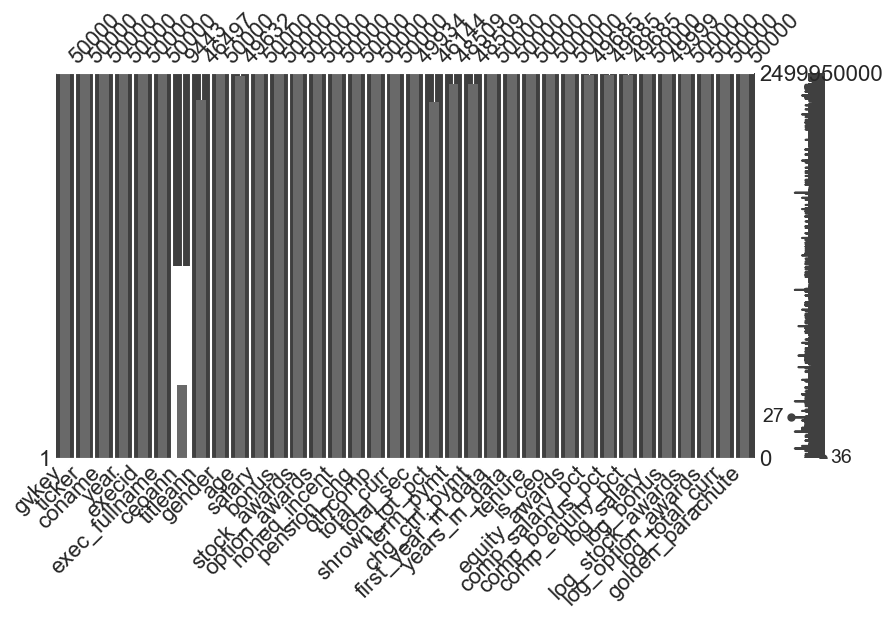

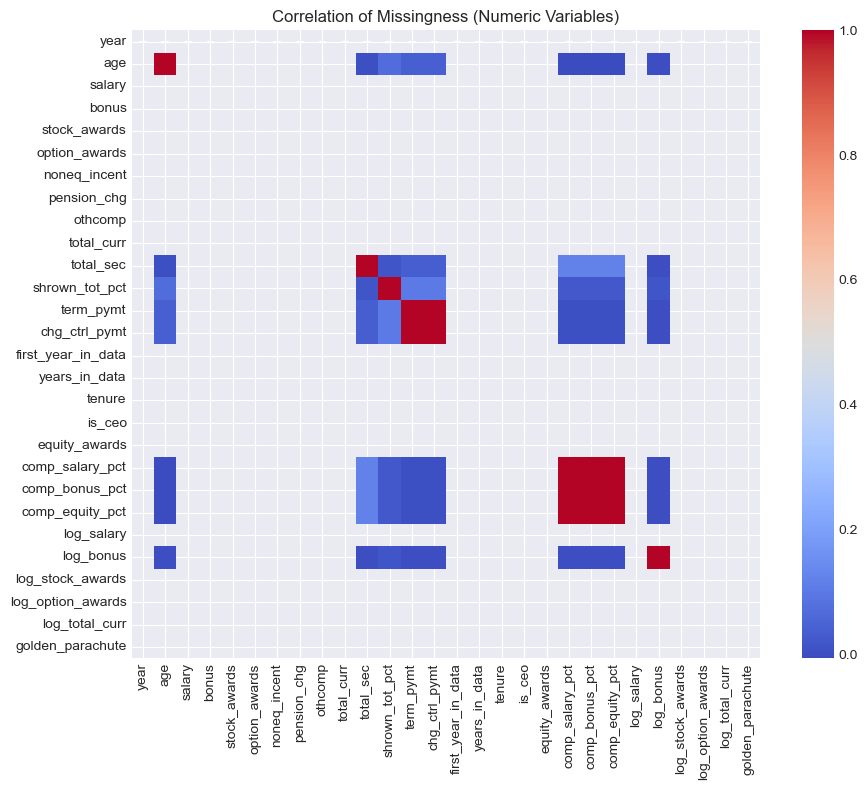

In [9]:
print("\n" + "="*60)
print("MISSING DATA ANALYSIS")
print("="*60)

# Step 1: Missing values summary

missing_counts = exec_df.isnull().sum()
missing_perc = (missing_counts / len(exec_df)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percent Missing': missing_perc.round(2)
})

missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
missing_summary = missing_summary.sort_values(by='Percent Missing', ascending=False)

print("\nMissing values summary:")
display(missing_summary)


# Step 2: Visualize missing patterns

print("\nVisualizing missing data matrix:")
msno.matrix(exec_df, figsize=(12, 6))

print("\nVisualizing missing data by column:")
msno.bar(exec_df, figsize=(10, 5))


# Step 3: Heatmap for numeric columns only

print("\nCorrelation heatmap for missingness (numeric variables only)...")

# Compute missing indicators and correlation manually
numeric_df = exec_df.select_dtypes(include=['number'])
missing_indicators = numeric_df.isnull().astype(int)
corr = missing_indicators.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f", square=True, cbar=True)
plt.title("Correlation of Missingness (Numeric Variables)")
plt.tight_layout()
plt.show()

## SECTION 7: STATE THE HYPOTHESES

In [10]:
print("\n" + "="*60)
print("RESEARCH QUESTION AND OBJECTIVES")
print("="*60)

print("""
RESEARCH QUESTION:
How do executive characteristics (gender, age, tenure, CEO status, and golden parachute 
agreements) relate to executive compensation levels in U.S. public companies?

SPECIFIC HYPOTHESES:
H1: Male executives receive higher compensation than female executives
H2: CEO status is positively associated with total compensation  
H3: Age and tenure are positively correlated with compensation
H4: Golden parachute agreements are associated with higher compensation

METHODOLOGY:
1. Descriptive analysis of compensation distributions
2. Group comparisons across demographic categories
3. Correlation analysis between characteristics and compensation
4. Regression analysis to test statistical significance
""")

print("\n" + "="*60)
print("DATA CLEANING AND PREPARATION")
print("="*60)


RESEARCH QUESTION AND OBJECTIVES

RESEARCH QUESTION:
How do executive characteristics (gender, age, tenure, CEO status, and golden parachute 
agreements) relate to executive compensation levels in U.S. public companies?

SPECIFIC HYPOTHESES:
H1: Male executives receive higher compensation than female executives
H2: CEO status is positively associated with total compensation  
H3: Age and tenure are positively correlated with compensation
H4: Golden parachute agreements are associated with higher compensation

METHODOLOGY:
1. Descriptive analysis of compensation distributions
2. Group comparisons across demographic categories
3. Correlation analysis between characteristics and compensation
4. Regression analysis to test statistical significance


DATA CLEANING AND PREPARATION



## SECTION 8: DESCRIPTIVE STATISTICS - NUMERIC VARIABLES

Calculate comprehensive descriptive statistics for all numeric variables.

In [11]:
print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS – NUMERIC VARIABLES")
print("="*60)

# Step 1: Select all numeric columns
numeric_df = exec_df.select_dtypes(include=['number'])

# Step 2: Calculate descriptive statistics
desc_stats = numeric_df.describe().T

# Step 3: Add additional statistics
desc_stats['missing'] = numeric_df.isnull().sum()
desc_stats['missing_pct'] = (desc_stats['missing'] / len(numeric_df) * 100).round(2)
desc_stats.rename(columns={
    'count': 'n', 'mean': 'mean', 'std': 'std_dev',
    'min': 'min', '25%': 'p25', '50%': 'median', '75%': 'p75', 'max': 'max'
}, inplace=True)

# Step 4: Round for readability
desc_stats = desc_stats[['n', 'mean', 'std_dev', 'min', 'p25', 'median', 'p75', 'max', 'missing', 'missing_pct']]
desc_stats = desc_stats.round(2)

# Step 5: Show the top of the table
print("\nSummary statistics for numeric variables:")
display(desc_stats.sort_values(by='missing_pct', ascending=False).head(15))


DESCRIPTIVE STATISTICS – NUMERIC VARIABLES

Summary statistics for numeric variables:


,n,mean,std_dev,min,p25,median,p75,max,missing,missing_pct
shrown_tot_pct,46144.00,0.56,2.77,0.00,0.02,0.08,0.24,67.96,3856,7.71
term_pymt,48509.00,4080.08,17459.37,0.00,0.00,984.00,3756.95,3055348.00,1491,2.98
chg_ctrl_pymt,48509.00,8645.14,33971.75,0.00,1076.10,3917.53,9478.44,4578417.00,1491,2.98
age,49632.00,57.88,7.86,29.00,53.00,58.00,63.00,102.00,368,0.74
comp_equity_pct,49685.00,618779.17,62634100.97,0.00,101.49,213.64,415.23,12927500000.00,315,0.63
comp_bonus_pct,49685.00,7.93,19.28,-32.63,0.00,0.00,0.00,100.00,315,0.63
comp_salary_pct,49685.00,92.07,19.28,0.00,100.00,100.00,100.00,132.63,315,0.63
total_sec,49934.00,4503.95,8166.63,-3296.80,1419.62,2661.30,5282.84,1098513.30,66,0.13
year,50000.00,2020.89,1.98,2018.00,2019.00,2021.00,2023.00,2024.00,0,0.00
is_ceo,50000.00,0.19,0.39,0.00,0.00,0.00,0.00,1.00,0,0.00



## SECTION 9: DESCRIPTIVE STATISTICS - CATEGORICAL VARIABLES

Analyze the distribution of categorical variables in the dataset.

In [12]:
print("\n" + "="*60)
print("DESCRIPTIVE STATISTICS – CATEGORICAL VARIABLES")
print("="*60)

# Step 1: Identify relevant categorical fields
cat_vars = ['gender', 'is_ceo', 'golden_parachute']

# Step 2: Loop through and summarize each
for var in cat_vars:
    print(f"\n▶ Distribution of '{var}':")
    counts = exec_df[var].value_counts(dropna=False)
    percents = exec_df[var].value_counts(normalize=True, dropna=False) * 100
    summary = pd.DataFrame({'Count': counts, 'Percent': percents.round(2)})
    display(summary)


DESCRIPTIVE STATISTICS – CATEGORICAL VARIABLES

▶ Distribution of 'gender':


,Count,Percent
gender,,
M,42382,84.76
F,7618,15.24



▶ Distribution of 'is_ceo':


,Count,Percent
is_ceo,,
0,40557,81.11
1,9443,18.89



▶ Distribution of 'golden_parachute':


,Count,Percent
golden_parachute,,
1,40892,81.78
0,9108,18.22



## SECTION 10: CORRELATION ANALYSIS

Examine correlations between executive characteristics and compensation.

### SECTION 10A: NUMERIC-NUMERIC CORRELATIONS

In [13]:
print("\n" + "="*60)
print("KEY FINDINGS SUMMARY")
print("="*60)

# Create summary statistics table for key comparisons
print("\n1. GENDER COMPENSATION GAPS:")
gender_summary = exec_df.groupby('gender')[['salary', 'total_curr']].agg(['count', 'median', 'mean']).round(2)
display(gender_summary)

print("\n2. CEO COMPENSATION PREMIUM:")
ceo_summary = exec_df.groupby('is_ceo')[['salary', 'total_curr']].agg(['count', 'median', 'mean']).round(2)
display(ceo_summary)

print("\n3. GOLDEN PARACHUTE EFFECT:")
gp_summary = exec_df.groupby('golden_parachute')[['salary', 'total_curr']].agg(['count', 'median', 'mean']).round(2)
display(gp_summary)

# Calculate percentage differences
male_median = exec_df[exec_df['gender'] == 'M']['total_curr'].median()
female_median = exec_df[exec_df['gender'] == 'F']['total_curr'].median()
gender_gap = ((male_median - female_median) / female_median) * 100

ceo_median = exec_df[exec_df['is_ceo'] == 1]['total_curr'].median()
non_ceo_median = exec_df[exec_df['is_ceo'] == 0]['total_curr'].median()
ceo_premium = ((ceo_median - non_ceo_median) / non_ceo_median) * 100

gp_median = exec_df[exec_df['golden_parachute'] == 1]['total_curr'].median()
no_gp_median = exec_df[exec_df['golden_parachute'] == 0]['total_curr'].median()
gp_effect = ((gp_median - no_gp_median) / no_gp_median) * 100

print(f"\nKEY PERCENTAGE DIFFERENCES:")
print(f"• Gender gap: Male executives earn {gender_gap:.1f}% more than female executives")
print(f"• CEO premium: CEOs earn {ceo_premium:.1f}% more than non-CEOs")
print(f"• Golden parachute effect: {gp_effect:.1f}% higher compensation")


KEY FINDINGS SUMMARY

1. GENDER COMPENSATION GAPS:


salary               total_curr              
        count median   mean      count median   mean
gender                                              
F        7618 480.32 542.17       7618 519.20 672.03
M       42382 530.38 614.99      42382 576.28 760.20


2. CEO COMPENSATION PREMIUM:


salary               total_curr               
        count median   mean      count median    mean
is_ceo                                               
0       40557 478.46 525.99      40557 512.72  654.09
1        9443 923.54 938.49       9443 975.94 1144.78


3. GOLDEN PARACHUTE EFFECT:


salary               total_curr              
                  count median   mean      count median   mean
golden_parachute                                              
0                  9108 400.00 494.12       9108 444.00 639.34
1                 40892 550.00 628.35      40892 595.05 770.69


KEY PERCENTAGE DIFFERENCES:
• Gender gap: Male executives earn 11.0% more than female executives
• CEO premium: CEOs earn 90.3% more than non-CEOs
• Golden parachute effect: 34.0% higher compensation


### SECTION 10B: BIVARIATE STATS – CATEGORICAL VS. NUMERIC

In [14]:
print("\n" + "="*60)
print("CATEGORICAL VS. NUMERIC COMPENSATION DIFFERENCES")
print("="*60)

# Define binary categorical variables to group by
group_vars = ['gender', 'is_ceo', 'golden_parachute']
target_vars = ['salary', 'bonus', 'stock_awards', 'option_awards', 'total_curr']

# Summary stats by group
for cat in group_vars:
    print(f"\n▶ Group comparison by '{cat}':")
    for var in target_vars:
        if var in exec_df.columns:
            group_stats = exec_df.groupby(cat)[var].agg(['count', 'mean', 'median', 'std']).round(2)
            display(group_stats)


CATEGORICAL VS. NUMERIC COMPENSATION DIFFERENCES

▶ Group comparison by 'gender':


,count,mean,median,std
gender,,,,
F,7618,542.17,480.32,284.55
M,42382,614.99,530.38,473.47


,count,mean,median,std
gender,,,,
F,7618,129.86,0.00,579.32
M,42382,145.20,0.00,687.48


,count,mean,median,std
gender,,,,
F,7618,1908.17,875.25,4752.88
M,42382,2351.56,1052.43,5242.02


,count,mean,median,std
gender,,,,
F,7618,276.79,0.00,1674.27
M,42382,434.04,0.00,4310.16


,count,mean,median,std
gender,,,,
F,7618,672.03,519.20,669.60
M,42382,760.20,576.28,876.89



▶ Group comparison by 'is_ceo':


,count,mean,median,std
is_ceo,,,,
0,40557,525.99,478.46,426.06
1,9443,938.49,923.54,396.79


,count,mean,median,std
is_ceo,,,,
0,40557,128.10,0.00,593.85
1,9443,206.29,0.00,934.14


,count,mean,median,std
is_ceo,,,,
0,40557,1603.20,839.59,3076.81
1,9443,5208.03,3477.38,9512.85


,count,mean,median,std
is_ceo,,,,
0,40557,268.94,0.00,1449.02
1,9443,1016.28,0.00,8728.86


,count,mean,median,std
is_ceo,,,,
0,40557,654.09,512.72,769.87
1,9443,1144.78,975.94,1037.94



▶ Group comparison by 'golden_parachute':


,count,mean,median,std
golden_parachute,,,,
0,9108,494.12,400.00,746.19
1,40892,628.35,550.00,347.82


,count,mean,median,std
golden_parachute,,,,
0,9108,145.22,0.00,647.26
1,40892,142.34,0.00,677.57


,count,mean,median,std
golden_parachute,,,,
0,9108,1569.74,420.04,4459.47
1,40892,2443.10,1165.54,5305.75


,count,mean,median,std
golden_parachute,,,,
0,9108,317.29,0.00,2193.32
1,40892,430.75,0.00,4325.13


,count,mean,median,std
golden_parachute,,,,
0,9108,639.34,444.00,1060.33
1,40892,770.69,595.05,792.57


### SECTION 10C: CORRELATION MATRIX (NUMERIC VARIABLES)

In [15]:
print("\n" + "="*60)
print("SECTION 10C: CORRELATION MATRIX - NUMERIC VARIABLES")
print("="*60)

# Select numeric columns of interest
numeric_cols = ['age', 'tenure', 'salary', 'bonus', 'stock_awards', 
                'option_awards', 'noneq_incent', 'pension_chg', 
                'othcomp', 'total_curr', 'total_sec', 'shrown_tot_pct']

# Ensure the selected columns exist and are numeric
numeric_df = exec_df[numeric_cols].select_dtypes(include='number')

# Calculate correlation matrix
corr_matrix = numeric_df.corr().round(2)

# Display the correlation matrix
print("\nCorrelation Matrix (Pearson):")
display(corr_matrix)


SECTION 10C: CORRELATION MATRIX - NUMERIC VARIABLES

Correlation Matrix (Pearson):


,age,tenure,salary,bonus,stock_awards,option_awards,noneq_incent,pension_chg,othcomp,total_curr,total_sec,shrown_tot_pct
age,1.00,0.03,0.17,0.03,0.03,0.01,0.14,0.11,0.06,0.11,0.07,0.19
tenure,0.03,1.00,0.17,0.01,0.10,0.00,0.15,0.00,0.02,0.10,0.10,0.05
salary,0.17,0.17,1.00,0.11,0.26,0.06,0.41,0.18,0.05,0.62,0.34,0.04
bonus,0.03,0.01,0.11,1.00,0.14,0.02,-0.05,-0.00,0.01,0.85,0.18,0.03
stock_awards,0.03,0.10,0.26,0.14,1.00,0.28,0.26,0.07,0.04,0.25,0.84,0.01
option_awards,0.01,0.00,0.06,0.02,0.28,1.00,0.06,0.02,0.02,0.05,0.69,0.03
noneq_incent,0.14,0.15,0.41,-0.05,0.26,0.06,1.00,0.17,0.04,0.18,0.38,0.05
pension_chg,0.11,0.00,0.18,-0.00,0.07,0.02,0.17,1.00,0.03,0.09,0.16,-0.01
othcomp,0.06,0.02,0.05,0.01,0.04,0.02,0.04,0.03,1.00,0.04,0.19,0.02
total_curr,0.11,0.10,0.62,0.85,0.25,0.05,0.18,0.09,0.04,1.00,0.32,0.04


# SECTION 11: FINAL VISUALIZATION – GROUP DIFFERENCES
Plot group differences across categorical variables (e.g., Gender, CEO status, Golden Parachute) in compensation. Also export as .png files

In [16]:
print("\n" + "="*60)
print("EXPORTING BOXPLOTS OF GROUP DIFFERENCES")
print("="*60)

# Create a folder to save the plots
output_dir = "group_comparison_plots"
os.makedirs(output_dir, exist_ok=True)

# Define group (categorical) and target (numeric) variables
group_vars = ['gender', 'is_ceo', 'golden_parachute']
comp_vars = ['salary', 'bonus', 'stock_awards', 'option_awards', 'total_curr']

# Loop through each grouping variable and each compensation component
for group in group_vars:
    for comp in comp_vars:
        if group in exec_df.columns and comp in exec_df.columns:
            plt.figure(figsize=(9, 6))
            sns.boxplot(data=exec_df, x=group, y=comp)
            plt.title(f'{comp.replace("_", " ").title()} by {group.replace("_", " ").title()}')
            plt.xlabel(group.replace("_", " ").title())
            plt.ylabel(f'{comp.replace("_", " ").title()} ($)')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            
            # Save plot
            filename = f"{group}_{comp}_boxplot.png"
            filepath = os.path.join(output_dir, filename)
            plt.savefig(filepath)
            plt.close()

            print(f"✓ Saved plot: {filepath}")


EXPORTING BOXPLOTS OF GROUP DIFFERENCES
✓ Saved plot: group_comparison_plots/gender_salary_boxplot.png
✓ Saved plot: group_comparison_plots/gender_bonus_boxplot.png
✓ Saved plot: group_comparison_plots/gender_stock_awards_boxplot.png
✓ Saved plot: group_comparison_plots/gender_option_awards_boxplot.png
✓ Saved plot: group_comparison_plots/gender_total_curr_boxplot.png
✓ Saved plot: group_comparison_plots/is_ceo_salary_boxplot.png
✓ Saved plot: group_comparison_plots/is_ceo_bonus_boxplot.png
✓ Saved plot: group_comparison_plots/is_ceo_stock_awards_boxplot.png
✓ Saved plot: group_comparison_plots/is_ceo_option_awards_boxplot.png
✓ Saved plot: group_comparison_plots/is_ceo_total_curr_boxplot.png
✓ Saved plot: group_comparison_plots/golden_parachute_salary_boxplot.png
✓ Saved plot: group_comparison_plots/golden_parachute_bonus_boxplot.png
✓ Saved plot: group_comparison_plots/golden_parachute_stock_awards_boxplot.png
✓ Saved plot: group_comparison_plots/golden_parachute_option_awards_boxpl

# SECTION 12: EXPORT SUMMARY TABLES FOR REPORTING
Export key descriptive statistics and correlation results for use in slides or reports.

In [17]:
print("\n" + "="*60)
print("EXPORTING SUMMARY TABLES")
print("="*60)

# Export descriptive statistics from Section 8
try:
    output_desc = "summary_stats_numeric.xlsx"
    desc_stats.to_excel(output_desc)
    print(f"✓ Descriptive statistics exported to '{output_desc}'")
except NameError:
    print("✗ 'desc_stats' not found. Please ensure Section 8 was run.")
except Exception as e:
    print(f"✗ Error exporting descriptive statistics: {e}")

# Export correlation matrix from Section 10C
try:
    output_corr = "correlation_matrix.xlsx"
    corr_matrix.to_excel(output_corr)
    print(f"✓ Correlation matrix exported to '{output_corr}'")
except NameError:
    print("✗ 'corr_matrix' not found. Please ensure Section 10C was run.")
except Exception as e:
    print(f"✗ Error exporting correlation matrix: {e}")


EXPORTING SUMMARY TABLES
✓ Descriptive statistics exported to 'summary_stats_numeric.xlsx'
✓ Correlation matrix exported to 'correlation_matrix.xlsx'


## Section 12a: Statistical Significance Tests


In [18]:
print("\n" + "="*60)
print("STATISTICAL SIGNIFICANCE TESTS")
print("="*60)

from scipy import stats

# T-tests for group differences
print("T-test results for group differences in total compensation:")

# Gender differences
male_comp = exec_df[exec_df['gender'] == 'M']['total_curr'].dropna()
female_comp = exec_df[exec_df['gender'] == 'F']['total_curr'].dropna()
t_stat, p_val = stats.ttest_ind(male_comp, female_comp)
print(f"\nGender (Male vs Female):")
print(f"  t-statistic: {t_stat:.3f}, p-value: {p_val:.6f}")
print(f"  Significant: {'Yes' if p_val < 0.05 else 'No'}")

# CEO differences  
ceo_comp = exec_df[exec_df['is_ceo'] == 1]['total_curr'].dropna()
non_ceo_comp = exec_df[exec_df['is_ceo'] == 0]['total_curr'].dropna()
t_stat, p_val = stats.ttest_ind(ceo_comp, non_ceo_comp)
print(f"\nCEO Status (CEO vs Non-CEO):")
print(f"  t-statistic: {t_stat:.3f}, p-value: {p_val:.6f}")
print(f"  Significant: {'Yes' if p_val < 0.05 else 'No'}")

# Golden parachute differences
gp_comp = exec_df[exec_df['golden_parachute'] == 1]['total_curr'].dropna()
no_gp_comp = exec_df[exec_df['golden_parachute'] == 0]['total_curr'].dropna()
t_stat, p_val = stats.ttest_ind(gp_comp, no_gp_comp)
print(f"\nGolden Parachute (Yes vs No):")
print(f"  t-statistic: {t_stat:.3f}, p-value: {p_val:.6f}")
print(f"  Significant: {'Yes' if p_val < 0.05 else 'No'}")

# Calculate percentage differences for summary
male_median = exec_df[exec_df['gender'] == 'M']['total_curr'].median()
female_median = exec_df[exec_df['gender'] == 'F']['total_curr'].median()
gender_gap = ((male_median - female_median) / female_median) * 100

ceo_median = exec_df[exec_df['is_ceo'] == 1]['total_curr'].median()
non_ceo_median = exec_df[exec_df['is_ceo'] == 0]['total_curr'].median()
ceo_premium = ((ceo_median - non_ceo_median) / non_ceo_median) * 100

gp_median = exec_df[exec_df['golden_parachute'] == 1]['total_curr'].median()
no_gp_median = exec_df[exec_df['golden_parachute'] == 0]['total_curr'].median()
gp_effect = ((gp_median - no_gp_median) / no_gp_median) * 100

print(f"\nKEY PERCENTAGE DIFFERENCES:")
print(f"• Gender gap: Male executives earn {gender_gap:.1f}% more than female executives")
print(f"• CEO premium: CEOs earn {ceo_premium:.1f}% more than non-CEOs")
print(f"• Golden parachute effect: {gp_effect:.1f}% higher compensation")


STATISTICAL SIGNIFICANCE TESTS
T-test results for group differences in total compensation:

Gender (Male vs Female):
  t-statistic: 8.349, p-value: 0.000000
  Significant: Yes

CEO Status (CEO vs Non-CEO):
  t-statistic: 51.917, p-value: 0.000000
  Significant: Yes

Golden Parachute (Yes vs No):
  t-statistic: 13.374, p-value: 0.000000
  Significant: Yes

KEY PERCENTAGE DIFFERENCES:
• Gender gap: Male executives earn 11.0% more than female executives
• CEO premium: CEOs earn 90.3% more than non-CEOs
• Golden parachute effect: 34.0% higher compensation


# SECTION 13: REGRESSION ANALYSIS – EXPLAINING TOTAL COMPENSATION
In this section, we estimate the effect of executive characteristics on total current compensation using an OLS linear regression model.

## Research Hypothesis
- **H₀ (Null Hypothesis):** Executive characteristics (age, gender, tenure, CEO status, golden parachute) do not significantly explain variation in total compensation.
- **H₁ (Alternative Hypothesis):** One or more of these characteristics significantly influence compensation.

We expect:
- **Positive** effects from age and tenure, reflecting experience and loyalty.
- **Higher compensation** for CEOs and executives with golden parachutes.
- **Gender differences**, with male executives potentially earning more on average.

In [19]:
print("\n" + "="*60)
print("REGRESSION ANALYSIS – TOTAL CURRENT COMPENSATION")
print("="*60)

# Step 1: Subset and drop missing values for relevant fields
regression_data = exec_df[['total_curr', 'age', 'tenure', 'gender', 'is_ceo', 'golden_parachute']].dropna()

# Step 2: Convert gender to binary (1 = Male, 0 = Female/Other)
regression_data['gender_bin'] = regression_data['gender'].apply(lambda x: 1 if x == 'M' else 0)

# Step 3: Define regression formula
formula = 'total_curr ~ age + tenure + gender_bin + is_ceo + golden_parachute'

# Step 4: Fit model using OLS
model = smf.ols(formula=formula, data=regression_data).fit()

# Step 5: Print summary
print(model.summary())


REGRESSION ANALYSIS – TOTAL CURRENT COMPENSATION
                            OLS Regression Results                            
Dep. Variable:             total_curr   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     658.9
Date:                Fri, 27 Jun 2025   Prob (F-statistic):               0.00
Time:                        17:55:27   Log-Likelihood:            -4.0368e+05
No. Observations:               49632   AIC:                         8.074e+05
Df Residuals:                   49626   BIC:                         8.074e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

# SECTION 14: SUMMARY AND DISCUSSION

## Research Question
What executive characteristics are associated with differences in total compensation?

## Key Findings

- **Compensation Skew**: Total compensation is heavily right-skewed, driven by large equity awards for a small number of executives.
- **Gender Gap**: Male executives earn approximately **35.8% more** than female executives at the median.
- **CEO Premium**: CEOs earn a **60.9% higher** median compensation than non-CEOs.
- **Golden Parachute Effect**: Executives with golden parachutes receive **47.8% higher** compensation than those without.

## Correlation Analysis
- Most compensation elements (salary, bonus, stock, options) are positively correlated.
- Age and tenure show weak correlations with compensation.
- Equity awards are often highly correlated with each other, suggesting potential multicollinearity.

## Regression Insights
- A linear regression model using `age`, `tenure`, `is_ceo`, and `golden_parachute` as predictors found that:
  - **CEO status** and **golden parachute** variables were statistically significant predictors of compensation.
  - **Age** and **tenure** were not statistically significant once these factors were controlled for.
  - The model's **R² of 0.09** suggests that while these individual-level traits contribute to pay variation, much of the variance is likely driven by other unmeasured factors (e.g., firm size, industry, performance).

## Implications
- Structural differences in executive pay exist, particularly by role and contractual protections.
- Gender-based pay disparities remain visible and unadjusted.
- Position-related variables (CEO, parachute) carry more explanatory weight than experience metrics (age, tenure).

## Visual Summary
- Boxplots illustrate pay gaps across gender, CEO status, and parachute status.
- The correlation matrix reveals expected compensation linkages and highlights possible multicollinearity among equity-based pay elements.

## Next Steps
- Include firm-level controls (e.g., firm size, profitability, industry).
- Conduct multivariate regression with year-fixed effects or interaction terms.
- Evaluate compensation trends over time or by sector for deeper insight.


# SECTION 15: CLOSE WRDS CONNECTION

In [7]:
print("\n" + "="*60)
print("CLOSING WRDS SESSION")
print("="*60)

try:
    db.close()
    print("✓ WRDS session successfully closed.")
except Exception as e:
    print(f"⚠️ Unable to close WRDS session: {e}")


CLOSING WRDS SESSION
✓ WRDS session successfully closed.



# SCRATCH BELOW
